# Знакомство с данными

1. Загрузите данные за май 2016 года.

2. Проведите фильтрацию: удалите поездки с

    нулевой длительностью
    нулевым количеством пассажиров
    нулевым расстоянием поездки по счётчику
    координатами начала, не попадающими в прямоугольник Нью-Йорка

Можно придумать ещё какие-то критерии для фильтрации данных; тем не менее, не стоит применять дополнительные фильтры: начиная с четвёртой недели вам предстоит сравнивать качество ваших прогнозов с качеством прогнозов других слушателей, и, чтобы это сравнение было корректным, нужно, чтобы данные у всех были предобработаны одинаково.

3. Агрегируйте данные за май 2016 года по часам и областям (можно использовать функцию stats.binned_statistic_2d, с которой вы сталкивались в заданиях четвёртого курса). Не забудьте проверить, что идентификаторы, которые вы присваиваете ячейкам, соответствуют приложенному выше файлу.

4. Выведите первые строки полученной таблицы с указанием времени, идентификатора зоны и количества поездок.

5. Постройте график количества поездок жёлтого такси из ячейки, содержащей Empire State Building.

6. Посчитайте, сколько в мае 2016 было пар час-ячейка, для которых не было совершено ни одной поездки.

In [1]:
import numpy as np
import pandas as pd
import seaborn
from scipy import stats
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Загружаем

In [3]:
%%time
df = pd.read_csv('yellow_tripdata_2016-05.csv', header=0, sep=',')

CPU times: user 31.8 s, sys: 3.08 s, total: 34.8 s
Wall time: 36.1 s


In [4]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-05-01 00:00:00,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,1,N,-73.983986,40.730099,1,15.0,0.5,0.5,1.50,0.0,0.3,17.80
1,2,2016-05-01 00:00:00,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,1,N,-73.975700,40.765469,1,7.5,0.5,0.5,0.88,0.0,0.3,9.68
2,2,2016-05-01 00:00:00,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,1,N,-73.980995,40.744633,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36
3,2,2016-05-01 00:00:00,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,1,N,-74.002258,40.733002,1,17.0,0.5,0.5,3.66,0.0,0.3,21.96
4,2,2016-05-01 00:00:00,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,1,N,-73.997498,40.737564,1,6.0,0.5,0.5,1.46,0.0,0.3,8.76


In [5]:
df.columns

Index([u'VendorID', u'tpep_pickup_datetime', u'tpep_dropoff_datetime',
       u'passenger_count', u'trip_distance', u'pickup_longitude',
       u'pickup_latitude', u'RatecodeID', u'store_and_fwd_flag',
       u'dropoff_longitude', u'dropoff_latitude', u'payment_type',
       u'fare_amount', u'extra', u'mta_tax', u'tip_amount', u'tolls_amount',
       u'improvement_surcharge', u'total_amount'],
      dtype='object')

In [6]:
# Нью-Йорк вписан в прямоугольник от -74.25559 до -73.70001 градусов долготы и от 40.49612 до 40.91553 широты. 
NY = (-74.25559, -73.70001, 40.49612, 40.91553)

## Чистим данные

In [9]:
%%time
# data = df[:100000]
data = df

data = data.drop(data[data.trip_distance < 0.01].index)
print "После удаления поездок с нулевым расстоянием: ", len(data)
data.drop(data[data.passenger_count < 1].index, inplace=True)
print "После удаления поездок с нулевым кол-ов пассажиров: ", len(data)
data.drop(data[data.tpep_pickup_datetime == data.tpep_dropoff_datetime].index, inplace=True)
print "После удаления поездок с нулевой длительностью: ", len(data)
data.drop(data[(data.pickup_longitude < NY[0]) | (data.pickup_longitude > NY[1]) |
               (data.pickup_latitude < NY[2]) | (data.pickup_latitude > NY[3])].index, inplace=True)
print "После удаления поездок с координатами начала не из Нью-Йорка: ", len(data)

После удаления поездок с нулевым расстоянием:  11763962
После удаления поездок с нулевым кол-ов пассажиров:  11763773
После удаления поездок с нулевой длительностью:  11763422
После удаления поездок с координатами начала не из Нью-Йорка:  11626521
CPU times: user 6.93 s, sys: 2.63 s, total: 9.56 s
Wall time: 9.99 s


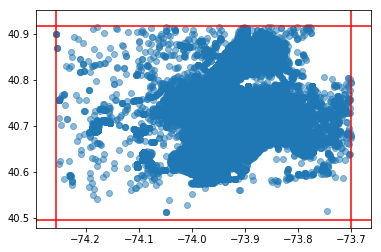

In [10]:
# посмотрим и убедимся что все точки на месте и нет лишних
X = data.pickup_longitude
Y = data.pickup_latitude
bin_count = 50

plt.scatter(X, Y, alpha=0.5)
plt.axvline(NY[0], color='r')
plt.axvline(NY[1], color='r')
plt.axhline(NY[2], color='r')
plt.axhline(NY[3], color='r')

## Загружаем регионы

In [11]:
regions = pd.read_csv('regions.csv', header=0, sep=';')
regions.head(10)

,region,west,east,south,north
0,1,-74.25559,-74.244478,40.496120,40.504508
1,2,-74.25559,-74.244478,40.504508,40.512896
2,3,-74.25559,-74.244478,40.512896,40.521285
3,4,-74.25559,-74.244478,40.521285,40.529673
4,5,-74.25559,-74.244478,40.529673,40.538061
5,6,-74.25559,-74.244478,40.538061,40.546449
6,7,-74.25559,-74.244478,40.546449,40.554837
7,8,-74.25559,-74.244478,40.554837,40.563226
8,9,-74.25559,-74.244478,40.563226,40.571614
9,10,-74.25559,-74.244478,40.571614,40.580002


Видно, что сначала регионы меняются с south-north, т.е. вдоль второй оси OY, посмотрим на метки угловых регионов Нью-Йорка, которые выдаст binned_statistic_2d

In [12]:
%%time
# координаты угловых точек Нью-Йорка
corner_X = [NY[0], NY[0], NY[1], NY[1]]
corner_Y = [NY[2], NY[3], NY[2], NY[3]]

bin_stat = stats.binned_statistic_2d(corner_X, corner_Y, None, statistic='count',
                                     bins=bin_count,
                                     range=[[NY[0], NY[1]], [NY[2], NY[3]]],
                                     expand_binnumbers=True)
print 'Номера ячеек:\n', bin_stat.binnumber

Номера ячеек:
[[ 1  1 50 50]
 [ 1 50  1 50]]


Теперь понятно как нужно пересчитать i,j номер ячейки в сквозной номер ячейки $i*binCount + j$

In [13]:
corner_Index = (bin_stat.binnumber[0] - 1) * bin_count + bin_stat.binnumber[1]
print corner_Index

[   1   50 2451 2500]


Теперь можно убедиться, что полученные сквозные номера регионов соответствуют правильным регионам

In [14]:
print regions.loc[corner_Index-1]

      region       west       east      south      north
0          1 -74.255590 -74.244478  40.496120  40.504508
49        50 -74.255590 -74.244478  40.907142  40.915530
2450    2451 -73.711122 -73.700010  40.496120  40.504508
2499    2500 -73.711122 -73.700010  40.907142  40.915530


# Статистики

3. Агрегируйте данные за май 2016 года по часам и областям (можно использовать функцию stats.binned_statistic_2d, с которой вы сталкивались в заданиях четвёртого курса). Не забудьте проверить, что идентификаторы, которые вы присваиваете ячейкам, соответствуют приложенному выше файлу.

4. Выведите первые строки полученной таблицы с указанием времени, идентификатора зоны и количества поездок.

5. Постройте график количества поездок жёлтого такси из ячейки, содержащей Empire State Building.

6. Посчитайте, сколько в мае 2016 было пар час-ячейка, для которых не было совершено ни одной поездки.

In [15]:
# Добавим еще один столбец - час начала поездки
data.insert(1, 'timestamp', data.tpep_pickup_datetime.apply(lambda x : x.split(':')[0]))

In [16]:
%%time
bin_stat = stats.binned_statistic_2d(X, Y, None, statistic='count',
                                     bins=bin_count,
                                     range=[[NY[0], NY[1]], [NY[2], NY[3]]],
                                     expand_binnumbers=True)
regions = (bin_stat.binnumber[0] - 1) * bin_count + bin_stat.binnumber[1]
print bin_stat.binnumber
print regions
# print bin_stat.x_edge
# print bin_stat.y_edge

[[25 24 24 ... 23 25 28]
 [33 30 30 ... 27 32 11]]
[1233 1180 1180 ... 1127 1232 1361]
CPU times: user 2.92 s, sys: 342 ms, total: 3.26 s
Wall time: 3.27 s


In [116]:
# Добавим еще один столбец - регион начала поездки
data.drop(['region'], inplace=True, axis=1, errors='ignore')
data.insert(1, 'region', regions)

## Агрегированная таблица время, идентификатор зоны и количество поездок.

In [117]:
aggregated = data[['timestamp','region']].groupby(['region', 'timestamp']).size().reset_index(name='counts')
P = pd.pivot_table(aggregated, index=['timestamp'], values=['counts'], columns=['region'], fill_value=0)
P

counts                                              ...        \
region          15   16   25   27   32   45   49   61   77   80   ...  2476   
timestamp                                                         ...         
2016-05-01 00      0    0    0    0    0    0    0    0    0    0 ...     0   
2016-05-01 01      0    0    0    0    0    0    0    0    0    0 ...     0   
2016-05-01 02      0    0    0    0    0    0    0    0    0    0 ...     0   
2016-05-01 03      0    0    0    0    0    0    0    0    0    0 ...     0   
2016-05-01 04      0    0    0    0    0    0    0    0    0    0 ...     0   
2016-05-01 05      0    0    0    0    0    0    0    0    0    0 ...     0   
2016-05-01 06      0    0    0    0    0    0    0    0    0    0 ...     0   
2016-05-01 07      0    0    0    0    0    0    0    0    0    0 ...     0   
2016-05-01 08      0    0    0    0    0    0    0    0    0    0 ...     0   
2016-05-01 09      0    0    0    0    0    0    0    0    0    0 ...     0   
2016-05-01 10      0    0    0    0    0    0    0    0    0    0 ...     0   
2016-05-01 11      0    0    0    0    0    0    0    0    0    0 ...     0   
2016-05-01 12      0    0    0    0    0    0    0    0    0    0 ...     0   
2016-05-01 13      0    0    0    0    0    0    0    0    0    0 ...     0   
2016-05-01 14      0    0    0    0    0    0    0    0    0    0 ...     0   
2016-05-01 15      0    0    0    0    0    0    0    0    0    0 ...     0   
2016-05-01 16      0    0    0    0    0    0    0    0    0    0 ...     0   
2016-05-01 17      0    0    0    0    1    0    0    0    0    0 ...     0   
2016-05-01 18      0    0    0    0    0    0    0    0    0    0 ...     0   
2016-05-01 19      0    0    0    0    0    0    0    0    0    0 ...     0   
2016-05-01 20      0    0    0    0    0    0    0    0    0    0 ...     0   
2016-05-01 21      0    0    0    0    0    0    0    0    0    0 ...     0   
2016-05-01 22      0    0    0    0    0    0    0    0    0    0 ...     0   
2016-05-01 23      0    0    0    0    0    0    0    0    0    0 ...     0   
2016-05-02 00      0    0    0    0    0    0    0    0    0    0 ...     0   
2016-05-02 01      0    0    0    0    0    0    0    0    0    0 ...     0   
2016-05-02 02      0    0    0    0    0    0    0    0    0    0 ...     0   
2016-05-02 03      0    0    0    0    0    0    0    0    0    0 ...     0   
2016-05-02 04      0    0    0    0    0    0    0    0    0    0 ...     0   
2016-05-02 05      0    0    0    0    0    0    0    0    0    0 ...     0   
...              ...  ...  ...  ...  ...  ...  ...  ...  ...  ... ...   ...   
2016-05-30 18      0    0    0    0    0    0    0    0    0    0 ...     0   
2016-05-30 19      0    0    0    0    0    0    0    0    0    0 ...     0   
2016-05-30 20      0    0    0    0    0    0    0    0    0    0 ...     0   
2016-05-30 21      0    0    0    0    0    0    0    0    0    0 ...     0   
2016-05-30 22      0    0    0    0    0    0    0    0    0    0 ...     0   
2016-05-30 23      0    0    0    0    0    0    0    0    0    0 ...     0   
2016-05-31 00      0    0    0    0    0    0    0    0    0    0 ...     0   
2016-05-31 01      0    0    0    0    0    0    0    0    0    0 ...     0   
2016-05-31 02      0    0    0    0    0    0    0    0    0    0 ...     0   
2016-05-31 03      0    0    0    0    0    0    0    0    0    0 ...     0   
2016-05-31 04      0    0    0    0    0    0    0    0    0    0 ...     0   
2016-05-31 05      0    0    0    0    0    0    0    0    0    0 ...     0   
2016-05-31 06      0    0    0    0    0    0    0    0    0    0 ...     0   
2016-05-31 07      0    0    0    0    0    0    0    0    0    0 ...     0   
2016-05-31 08      0    0    0    0    0    0    0    0    0    0 ...     0   
2016-05-31 09      0    0    0    0    0    0    0    0    0    0 ...     0   
2016-05-31 10      0    0    0    0    0    0    0    0    0    

## Посчитайте, сколько в мае 2016 было пар час-ячейка, для которых не было совершено ни одной поездки.

In [118]:
uniq = aggregated[['region', 'timestamp']].drop_duplicates().T
uniq

,0,1,2,3,4,5,6,7,8,9,...,141752,141753,141754,141755,141756,141757,141758,141759,141760,141761
region,15,16,25,27,32,32,32,32,32,32,...,2483,2483,2484,2485,2485,2486,2486,2486,2487,2487
timestamp,2016-05-20 13,2016-05-23 08,2016-05-04 13,2016-05-30 03,2016-05-01 17,2016-05-07 22,2016-05-18 11,2016-05-18 12,2016-05-18 13,2016-05-18 14,...,2016-05-02 01,2016-05-31 09,2016-05-01 16,2016-05-09 12,2016-05-12 21,2016-05-02 02,2016-05-10 11,2016-05-10 14,2016-05-12 21,2016-05-22 20


In [119]:
print "Кол-во уникальных пар час-ячейка (была совершена хотя бы одна поездка):", uniq.columns.size
print "Кол-во пар час-ячейка, для которых не было совершено ни одной поездки:", 2500 * 24 * 31 - uniq.columns.size

Кол-во уникальных пар час-ячейка (была совершена хотя бы одна поездка): 141762
Кол-во пар час-ячейка, для которых не было совершено ни одной поездки: 1718238


## Постройте график количества поездок жёлтого такси из ячейки, содержащей Empire State Building.

In [120]:
# https://www.latlong.net/place/empire-state-building-new-york-ny-usa-5312.html
X = [-73.985428]
Y = [40.748817]

bin_stat = stats.binned_statistic_2d(X, Y, values=H, statistic='count',
                                     bins=bin_count,
                                     range=[[NY[0], NY[1]], [NY[2], NY[3]]],
                                     expand_binnumbers=True)
regions = (bin_stat.binnumber[0] - 1) * bin_count + bin_stat.binnumber[1]

744


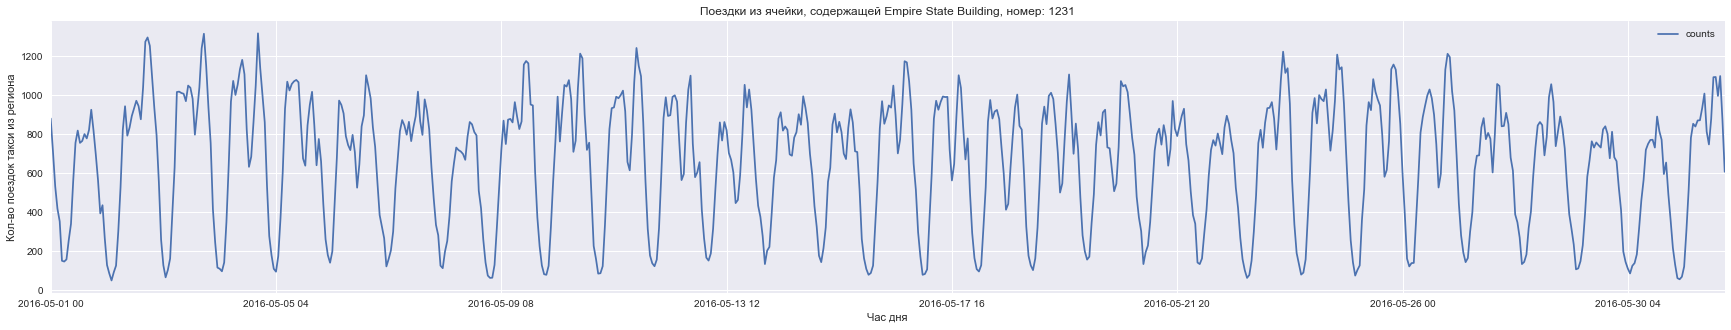

In [121]:
ESB_region = regions[0]
ESB = aggregated[aggregated['region'] == ESB_region].sort_values(by='timestamp', ascending=True)
print ESB.region.size
ESB.plot(x='timestamp', y='counts', figsize=(30,5))
plt.xlabel(u'Час дня')
plt.ylabel(u'Кол-во поездок такси из региона')
plt.title(u'Поездки из ячейки, содержащей Empire State Building, номер: %i' % ESB_region)